In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pylab import rcParams

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# importing libraries
import math
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import *
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
#from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
etf=pd.read_csv('/content/drive/Shareddrives/Capstone B1/Spinnaker Data/US Sector Inst ETF.csv')
institutional=pd.read_csv('/content/drive/Shareddrives/Capstone B1/Spinnaker Data/US Sector Institutional MF.csv') 
retail=pd.read_csv('/content/drive/Shareddrives/Capstone B1/Spinnaker Data/US Sector Retail MF.csv')

In [ ]:
missingAsset = 'Infrastructure-North America-USA-North America-Equity'

etf.drop(etf[etf['AssetClass'] == missingAsset].index, inplace=True)
institutional.drop(institutional[institutional['AssetClass'] == missingAsset].index, inplace=True)
retail.drop(retail[retail['AssetClass'] == missingAsset].index, inplace=True)

In [ ]:
# ARIMAX Model

# define a function for preprocessing dataset
def preprocessing(df): 
  # trim AssetClass names
  df['AssetClass'] = df['AssetClass'].str.replace('-North America-USA-North America-Equity', '')

  # convert ReportDate to datetime 
  df['ReportDate'] = pd.to_datetime(df["ReportDate"])
  
  # extract year
  df['year'] = df['ReportDate'].dt.year

  # set ReportDate as index
  df.sort_values("ReportDate", inplace=True)
  df.set_index('ReportDate', inplace=True)
  return df

In [ ]:
etf = preprocessing(etf)
grouped = etf.groupby(etf['AssetClass'])

com_model1 = grouped.get_group('Commodities/Materials')
con_model1 = grouped.get_group('Consumer Goods')
ene_model1 = grouped.get_group('Energy')
fin_model1 = grouped.get_group('Financials')
hea_model1 = grouped.get_group('Health Care/Biotech')
ind_model1 = grouped.get_group('Industrials')
lcb_model1 = grouped.get_group('Large Cap Blend')
lcg_model1 = grouped.get_group('Large Cap Growth')
lcv_model1 = grouped.get_group('Large Cap Value')
mcb_model1 = grouped.get_group('Mid Cap Blend')
mcg_model1 = grouped.get_group('Mid Cap Growth')
mcv_model1 = grouped.get_group('Mid Cap Value')
rea_model1 = grouped.get_group('Real Estate')
scb_model1 = grouped.get_group('Small Cap Blend')
scg_model1 = grouped.get_group('Small Cap Growth')
scv_model1 = grouped.get_group('Small Cap Value')
tec_model1 = grouped.get_group('Technology')
tel_model1 = grouped.get_group('Telecom')
uti_model1 = grouped.get_group('Utilities')

In [ ]:
tec_model1

,AssetClass,Flow,FlowPct,AssetsEnd,PortfolioChangePct,year
ReportDate,,,,,,
2006-01-04,Technology,7.951177,0.5318,1533.259850,2.0328,2006
2006-01-11,Technology,27.349755,1.7837,1641.107581,5.2501,2006
2006-01-18,Technology,45.189108,2.7535,1636.459468,-3.0368,2006
2006-01-25,Technology,-63.234264,-3.8640,1554.378023,-1.1516,2006
2006-02-01,Technology,-13.639647,-0.8774,1576.825113,2.3216,2006
...,...,...,...,...,...,...
2017-01-04,Technology,102.862047,0.2704,38338.186347,0.5422,2017
2017-01-11,Technology,441.392293,1.1511,39472.923445,1.7914,2017
2017-01-18,Technology,-212.668578,-0.5387,39226.390114,-0.0887,2017


In [ ]:
# Test for Stationarity
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [ ]:
DF = tec_model1.copy()

In [ ]:
DF['M16'] = DF['AssetsEnd'].rolling(16).mean()
DF['M50'] = DF['AssetsEnd'].rolling(50).mean()

DF['M16'] = DF['M16'].fillna(method="bfill")
DF['M50'] = DF['M50'].fillna(method="bfill")

DF['Buy'] = np.where(DF['M16']>DF['M50'],1.0,0.0)
DF['Short'] = np.where(DF['M16']<DF['M50'],1.0,0.0)    
    
#DF['roi'] = (DF['AssetsEnd'] - DF['AssetsEnd'][0])/DF['AssetsEnd'][0]
#DF['percent_change'] = (DF['AssetsEnd'] - DF['AssetsEnd'].shift(1))/DF['AssetsEnd'].shift(1)
#DF['percent_change'] = DF['percent_change'].fillna(0)

In [ ]:
DF.drop(['AssetClass','year'],axis=1,inplace=True)

In [ ]:
DF

,Flow,FlowPct,AssetsEnd,PortfolioChangePct,M16,M50,Buy,Short
ReportDate,,,,,,,,
2006-01-04,7.951177,0.5318,1533.259850,2.0328,2693.853797,3122.995051,0.0,1.0
2006-01-11,27.349755,1.7837,1641.107581,5.2501,2693.853797,3122.995051,0.0,1.0
2006-01-18,45.189108,2.7535,1636.459468,-3.0368,2693.853797,3122.995051,0.0,1.0
2006-01-25,-63.234264,-3.8640,1554.378023,-1.1516,2693.853797,3122.995051,0.0,1.0
2006-02-01,-13.639647,-0.8774,1576.825113,2.3216,2693.853797,3122.995051,0.0,1.0
...,...,...,...,...,...,...,...,...
2017-01-04,102.862047,0.2704,38338.186347,0.5422,36094.001050,32656.647016,1.0,0.0
2017-01-11,441.392293,1.1511,39472.923445,1.7914,36405.509709,32863.184929,1.0,0.0
2017-01-18,-212.668578,-0.5387,39226.390114,-0.0887,36697.135525,33056.312406,1.0,0.0


A SARIMAX model is used to train on the training split. The training split contains 1400 examples. The model will then be evaluated on a hold out validation set. This will give us a rough idea on how our model performs on data it has not seen. This will help us tune our model properly and help us get a lower RMSE score on testing set.

Training the model on entire training split

In [ ]:
df = DF[:int(len(DF)*0.8)]
test_df = DF[int(len(DF)*0.8):]

In [ ]:
test_df

,Flow,FlowPct,AssetsEnd,PortfolioChangePct,M16,M50,Buy,Short
ReportDate,,,,,,,,
2014-11-19,19.579354,0.0638,30846.337998,0.5654,29370.319145,27415.893433,1.0,0.0
2014-11-26,110.030996,0.3567,31674.605768,2.3276,29586.202677,27584.227793,1.0,0.0
2014-12-03,601.942018,1.8967,32309.382910,-0.0855,29813.728561,27758.349068,1.0,0.0
2014-12-10,145.516629,0.4503,31617.817436,-2.5899,29956.826919,27909.019922,1.0,0.0
2014-12-17,-52.047258,-0.1646,31277.444200,-0.9098,30060.648630,28047.257649,1.0,0.0
...,...,...,...,...,...,...,...,...
2017-01-04,102.862047,0.2704,38338.186347,0.5422,36094.001050,32656.647016,1.0,0.0
2017-01-11,441.392293,1.1511,39472.923445,1.7914,36405.509709,32863.184929,1.0,0.0
2017-01-18,-212.668578,-0.5387,39226.390114,-0.0887,36697.135525,33056.312406,1.0,0.0


In [ ]:
df = DF[:int(len(DF)*0.8)].reset_index(drop=True)
test_df = DF[int(len(DF)*0.8):].reset_index(drop=True)
sc1 = StandardScaler()
sc2 = StandardScaler()
columns = ['Flow','FlowPct','PortfolioChangePct','M16','M50','Buy','Short']
df[columns] = sc1.fit_transform(df[columns])
test_df[columns] = sc1.transform(test_df[columns])
df['AssetsEnd'] = sc2.fit_transform(df[['AssetsEnd']])


model = SARIMAX(endog=df['AssetsEnd'],exog=df[columns],order=(2,0,0),seasonal_order=(0,1,2,16),trend=[1,0,1,1],trend_offset=7,enforce_invertibility=False,enforce_stationarity=False,start_params=[0,0,1,0,1,2,1,2])
model_fit = model.fit(disp=0,maxiter=50,cov_type="robust",method="lbfgs")

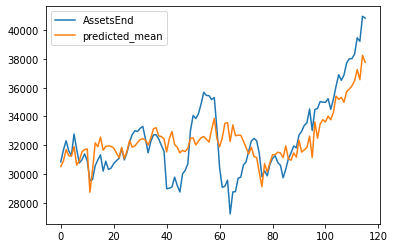

In [ ]:
future = model_fit.forecast(steps=len(test_df),exog = test_df[columns],dynamic=False)

future = sc2.inverse_transform(future.values.reshape(-1,1))

future = pd.Series(future.reshape(-1),name='predicted_mean',index=test_df["AssetsEnd"].index)
ans = pd.concat([test_df["AssetsEnd"],future],axis=1)
ans.plot()

In [ ]:
future

0      30517.119042
1      30898.991917
2      31695.403265
3      31270.282768
4      31244.250912
           ...     
111    36472.219091
112    37268.233414
113    36560.174664
114    38261.656246
115    37770.672411
Name: predicted_mean, Length: 116, dtype: float64

In [ ]:
rmse = math.sqrt(mean_squared_error(test_df["AssetsEnd"],future))
rmse

1766.3098929614846

In [ ]:
# Moving Average based training signals
short_window = 8
long_window = 20

signals = pd.DataFrame(index=future.index)
signals['signal'] = 0.0

signals['short_mavg'] = future.rolling(window=short_window, min_periods=1, center=False).mean()
signals['long_mavg'] = future.rolling(window=long_window, min_periods=1, center=False).mean()
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   
signals['positions'] = signals['signal'].diff()

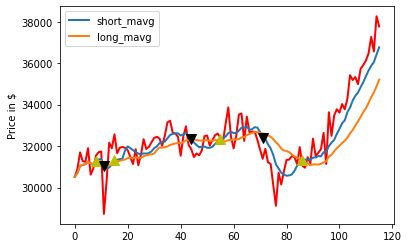

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111,  ylabel='Price in $')
future.plot(ax=ax1, color='r', lw=2.)


signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='y')

ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='k')
         
plt.show()

In [ ]:
signals_2 = pd.DataFrame(index=test_df["AssetsEnd"].index)
signals_2['signal'] = 0.0

signals_2['short_mavg'] = test_df["AssetsEnd"].rolling(window=short_window, min_periods=1, center=False).mean()
signals_2['long_mavg'] = test_df["AssetsEnd"].rolling(window=long_window, min_periods=1, center=False).mean()
signals_2['signal'][short_window:] = np.where(signals_2['short_mavg'][short_window:] 
                                            > signals_2['long_mavg'][short_window:], 1.0, 0.0)   
signals_2['positions'] = signals_2['signal'].diff()

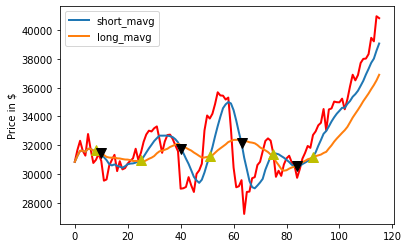

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111,  ylabel='Price in $')
test_df["AssetsEnd"].plot(ax=ax1, color='r', lw=2.)


signals_2[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)
ax1.plot(signals_2.loc[signals_2.positions == 1.0].index, 
         signals_2.short_mavg[signals_2.positions == 1.0],
         '^', markersize=10, color='y')

ax1.plot(signals_2.loc[signals_2.positions == -1.0].index, 
         signals_2.short_mavg[signals_2.positions == -1.0],
         'v', markersize=10, color='k')
         
plt.show()

In [ ]:
from sklearn import metrics
auc = metrics.roc_auc_score(signals_2['signal'], signals['signal'])
print(auc)

0.6388221153846154
